# Colima Inversion Examples



In [1]:
%matplotlib inline
from utils import *
import io_utils as io
import vis_utils as vis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta, expon
from scipy.sparse.linalg import lsqr
from scipy.optimize import minimize
from time import process_time
from functools import reduce
from utils import *
from pandas import ExcelWriter
from pandas import ExcelFile
import xlrd
import re

In [2]:
filename = "./data/colima/colima_real_data.csv"

raw_df = pd.read_csv(filename)

phi_labels = [
    "[-5,-4)",
    "[-4,-3)" ,
    "[-3,-2)",
    "[-2,-1)",
    "[-1,0)",
    "[0,1)",
    "[1,2)",
    "[2,3)",
    "[3,4)"
]

ventx = 645110
venty = 2158088

raw_df["Easting"] = raw_df["Easting"] - ventx
raw_df["Northing"] = raw_df["Northing"] - venty

for phi in phi_labels:
    raw_df[phi] = (raw_df[phi].values)*100
    
raw_df["radius"] = np.sqrt(raw_df["Easting"]**2 + raw_df["Northing"]**2)

display(raw_df.head())

,Sample no.,Easting,Northing,MassArea,Thickness,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius
0,VF95-06a,3133,9522,417.20,40,0.0,11.0,21.0,22.0,23.0,17.0,4.0,0.0,0.0,10024.179418
1,VF95-08a,1907,8096,312.90,30,1.0,13.0,19.0,24.0,25.0,16.0,3.0,0.0,0.0,8317.563646
2,VF97-20Q,5500,8723,208.60,20,2.0,7.0,14.0,21.0,26.0,21.0,6.0,1.0,1.0,10312.164128
3,VF98-01a3,2665,9054,239.89,23,4.0,13.0,18.0,21.0,23.0,15.0,3.0,0.0,0.0,9438.068711
4,VF98-02a,1154,7735,156.45,15,1.0,12.0,19.0,23.0,24.0,17.0,3.0,0.0,0.0,7820.610015


## Preprossessing Steps

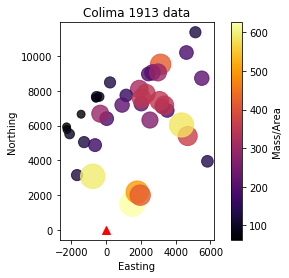

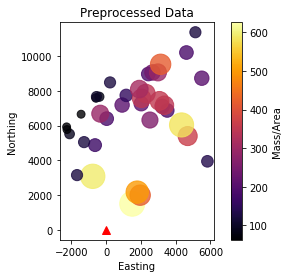

In [3]:
vis.plot_sample(raw_df, vent=(0,0), log=False, title="Colima 1913 data", cbar_label="Mass/Area")
plt.show()
# plt.savefig("colima/all_points.png", dpi=200, format='png')

obs_df = raw_df.copy()
obs_df["radius"] = np.sqrt(obs_df["Easting"]**2 + obs_df["Northing"]**2)

obs_df = obs_df.sort_values(by=['radius'])\

#This is going to be 100 across. Just needs to be the same as the other dfs. 
obs_df["Residual"] = obs_df["MassArea"]/obs_df["MassArea"]*100

# Uncomment to drop proximal points
# obs_df = obs_df[obs_df["radius"]>3500]

vis.plot_sample(obs_df, vent=(0,0), log=False, title="Preprocessed Data", cbar_label="Mass/Area")
# plt.savefig("colima/All_trans.png", dpi=200, format='png')
plt.show()

In [4]:
grid = obs_df[["Easting", "Northing"]].copy()
grid["Elevation"] = np.zeros(len(grid))
grid.to_csv("data/colima/colima_grid.csv", sep=" ", header=False, index=False)

t2_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_sim_data.txt")

# Order of these 3 commands matter
t2_df["radius"] = np.sqrt(t2_df["Easting"]**2 + t2_df["Northing"]**2)
t2_df = t2_df.sort_values(by=['radius'])
t2_df["Residual"] = t2_df["MassArea"].values/obs_df["MassArea"].values*100

display(t2_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,0,732.730,23.15290,25.4668,22.2407,15.7304,8.99492,3.44384,0.823464,0.136596,0.010359,2124.861643,117.086929
18,1957,1997,0,691.154,21.35410,24.7682,22.4602,16.5434,9.82586,3.90198,0.968656,0.164832,0.012894,2796.043276,165.664909
17,1787,2173,0,709.841,21.21370,24.7100,22.4801,16.6062,9.88889,3.93999,0.980849,0.167220,0.013114,2813.413940,141.786713
37,-770,3082,0,301.066,13.80220,19.2173,22.1297,20.4626,14.72470,7.12663,2.105690,0.398324,0.032906,3176.731654,50.641032
31,-1673,3152,0,149.680,9.51561,14.8613,20.3208,22.2637,18.49420,10.31720,3.459940,0.706562,0.060698,3568.477687,119.590924


In [5]:
t2_const_df, _, _, _ = io.read_tephra2("data/colima/colima_tephra2_const_wind_sim_data.txt")

# Order of these 3 commands matter
t2_const_df["radius"] = np.sqrt(t2_const_df["Easting"]**2 + t2_const_df["Northing"]**2)
t2_const_df = t2_const_df.sort_values(by=['radius'])
t2_const_df["Residual"] = t2_const_df["MassArea"]/obs_df["MassArea"]*100

display(t2_const_df.head())

,Easting,Northing,Elevation,MassArea,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",radius,Residual
16,1499,1506,2500,1394.460,17.2005,24.2121,24.7779,18.9162,10.8457,3.58293,0.449327,0.015328,0.000028,2124.861643,222.828380
18,1957,1997,2500,1216.150,14.0160,22.3619,24.8640,20.2838,12.7356,4.93885,0.769130,0.030705,0.000063,2796.043276,291.502876
17,1787,2173,2500,1251.000,13.8770,22.2837,24.8861,20.3522,12.8046,4.98427,0.780754,0.031310,0.000064,2813.413940,249.880153
37,-770,3082,2500,359.399,14.8025,22.8299,24.5313,19.4545,12.2828,5.13528,0.922533,0.041096,0.000091,3176.731654,60.452978
31,-1673,3152,2500,134.301,15.3664,23.3283,24.4813,18.8191,11.7036,5.16746,1.079070,0.054478,0.000132,3568.477687,107.303452


In [6]:
config = {}
with open("data/colima/colima_config.txt") as f:
    for line in f:
        line = line.strip()
        if not line=="" and not line.startswith("#"):
            (key, val) = line.split()
            config[str(key)] = float(val)

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}




# Update parameters
config["COL_STEPS"] = 20
config["PART_STEPS"] = 9

config["MAX_GRAINSIZE"] = -5
config["MIN_GRAINSIZE"] = 4

# Additional parameter: Constant wind speed
config["WIND_SPEED"] = 10

print("INPUT PARAMETERS:")
display(config)
display(globs)

INPUT PARAMETERS:


{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 3085.0,
 'PLUME_HEIGHT': 24000.0,
 'ALPHA': 1.02,
 'BETA': 1.56,
 'ERUPTION_MASS': 55000000000.0,
 'MAX_GRAINSIZE': -5,
 'MIN_GRAINSIZE': 4,
 'MEDIAN_GRAINSIZE': -1.8,
 'STD_GRAINSIZE': 2.4,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 4016.0,
 'FALL_TIME_THRESHOLD': 6458.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 20,
 'PART_STEPS': 9,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

,centroid,density,interval,lower,probability,upper
0,-4.5,1024.0,"[-5,-4)",-5.0,0.068338,-4.0
1,-3.5,1024.0,"[-4,-3)",-4.0,0.109203,-3.0
2,-2.5,1024.0,"[-3,-2)",-3.0,0.146694,-2.0
3,-1.5,1024.0,"[-2,-1)",-2.0,0.165650,-1.0
4,-0.5,1024.0,"[-1,0)",-1.0,0.157243,0.0
5,0.5,1233.5,"[0,1)",0.0,0.125474,1.0
6,1.5,1443.0,"[1,2)",1.0,0.084166,2.0
7,2.5,1652.5,"[2,3)",2.0,0.047459,3.0
8,3.5,1862.0,"[3,4)",3.0,0.022496,4.0


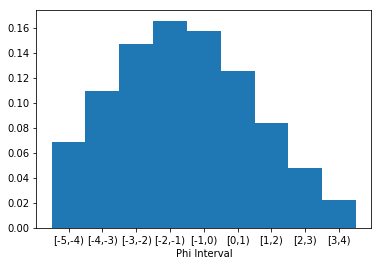

In [7]:
phi_steps = get_phi_steps(config["MIN_GRAINSIZE"], config["MAX_GRAINSIZE"], 
                          config["PART_STEPS"], 
                          config["MEDIAN_GRAINSIZE"], config["STD_GRAINSIZE"],
                          globs["LITHIC_DIAMETER_THRESHOLD"], 
                          globs["PUMICE_DIAMETER_THRESHOLD"], 
                          config["LITHIC_DENSITY"], config["PUMICE_DENSITY"])
step_width = (config["MAX_GRAINSIZE"] - config["MIN_GRAINSIZE"])/config["PART_STEPS"]

display(pd.DataFrame(phi_steps))



probs = [phi["probability"] for phi in phi_steps]
x = [phi["centroid"] for phi in phi_steps]
labels = [phi["interval"] for phi in phi_steps]
fig, ax = plt.subplots()
ax.bar(x, probs, width=1, align="center")
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.xlabel("Phi Interval")
plt.show()

In [8]:
t = process_time()
t_tot = process_time()
df_list = []

q_dist = beta(config["ALPHA"],config["BETA"])

grid = obs_df[["Easting", "Northing"]]
wind_angle = np.radians(55)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
for phi_step in phi_steps:
    mass_in_phi = config["ERUPTION_MASS"] * phi_step["probability"]
    input_table, gsm_df, sig, vv, tft= gaussian_stack_single_phi(
        grid, 20, config["VENT_ELEVATION"], 
        config["PLUME_HEIGHT"], 
        (config["ALPHA"], config["BETA"]),
        mass_in_phi, (u,v), 
        phi_step["lower"], phi_step["density"], 2500,
        config["DIFFUSION_COEFFICIENT"],
        config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"])
    df_list.append(gsm_df.rename(columns={"MassArea":phi_step["interval"]}))


elapsed_time = process_time() - t
print("Forward Sim time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge = reduce(lambda x, y: pd.merge(x, y, on =['Northing', 'Easting']), df_list)
elapsed_time = process_time() - t
print("Dataframe Merge time: %.5f seconds"%elapsed_time)

t = process_time()
df_merge["MassArea"] = np.sum(df_merge[labels], 1)
elapsed_time = process_time() - t
print("Tot M/A calc time: %.5f seconds"%elapsed_time)

t = process_time()
for label in labels:
    df_merge[label] = df_merge.apply(lambda row: (row[label]/row["MassArea"])*100, axis=1) # This operation is much faster

elapsed_time = process_time() - t
print("Phi Wt perc calc time: %.5f seconds"%elapsed_time)

total_time = process_time() - t_tot
print("Total time: %.5f seconds"%total_time)

forward_df = df_merge

# forward_df["MassArea"] = forward_df["MassArea"]*(6991/9469)

forward_df["radius"] = np.sqrt(forward_df["Easting"]**2 + forward_df["Northing"]**2)
forward_df = forward_df.sort_values(by=['radius'])
forward_df["Residual"] = forward_df["MassArea"].values/obs_df["MassArea"].values*100
display(forward_df.head())

Forward Sim time: 0.03125 seconds
Dataframe Merge time: 0.01562 seconds
Tot M/A calc time: 0.00000 seconds
Phi Wt perc calc time: 0.03125 seconds
Total time: 0.07812 seconds


,Northing,Easting,"[-5,-4)","[-4,-3)","[-3,-2)","[-2,-1)","[-1,0)","[0,1)","[1,2)","[2,3)","[3,4)",MassArea,radius,Residual
0,1506,1499,17.023654,24.058691,24.746126,19.010648,10.986457,3.680616,0.476505,0.017266,0.000036,1316.804462,2124.861643,210.419377
1,1997,1957,13.849036,22.187896,24.802962,20.364657,12.884741,5.062941,0.813217,0.034469,0.000080,1148.987823,2796.043276,275.404560
2,2173,1787,13.800371,22.209864,24.864958,20.379976,12.855621,5.043105,0.811521,0.034502,0.000081,1166.987337,2813.413940,233.099101
3,3082,-770,15.561092,23.674710,24.901902,19.059630,11.448421,4.522511,0.794749,0.036892,0.000093,300.904559,3176.731654,50.613877
4,3152,-1673,16.255639,24.321103,24.942842,18.429623,10.768184,4.367639,0.869463,0.045380,0.000126,111.014810,3568.477687,88.698314


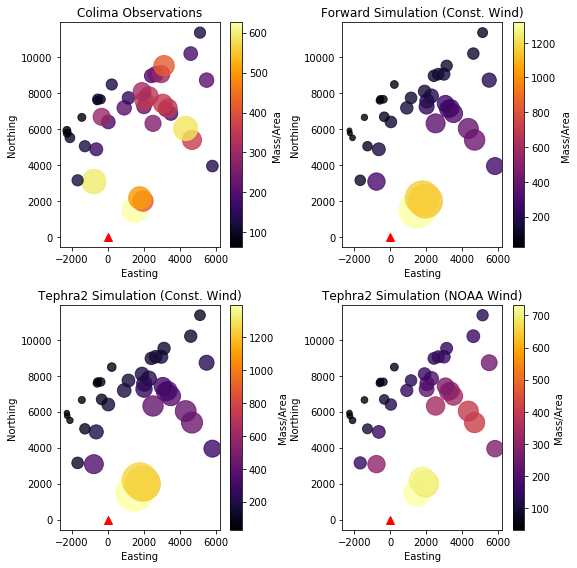

c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


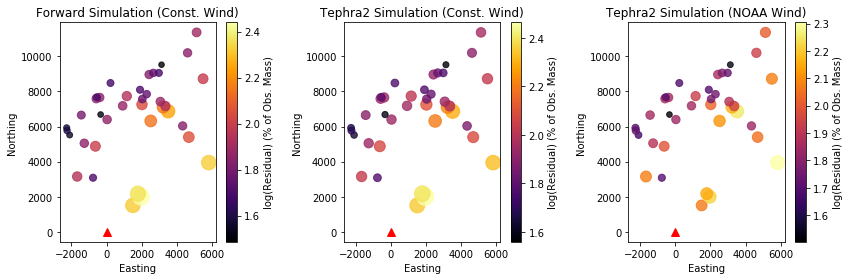

In [9]:
fig, axs = plt.subplots(2,2, figsize=(
        8,8), facecolor='w', edgecolor='k')
axs = axs.ravel()

vis.plot_sample(obs_df, vent=(0,0), log=False, 
            title="Colima Observations", cbar_label="Mass/Area", ax=axs[0])
vis.plot_sample(forward_df, vent=(0,0), log=False, 
            title="Forward Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[1])
vis.plot_sample(t2_const_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (Const. Wind)", cbar_label="Mass/Area", ax=axs[2])
vis.plot_sample(t2_df, vent=(0,0), log=False, 
            title="Tephra2 Simulation (NOAA Wind)", cbar_label="Mass/Area", ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1,3, figsize=(
        12,4), facecolor='w', edgecolor='k')
axs = axs.ravel()


vis.plot_sample(forward_df, vent=(0,0), log=True, values="Residual",
            title="Forward Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[0])
vis.plot_sample(t2_const_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (Const. Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[1])
vis.plot_sample(t2_df, vent=(0,0), log=True, values="Residual",
            title="Tephra2 Simulation (NOAA Wind)", 
            cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[2])




plt.tight_layout()
plt.show()

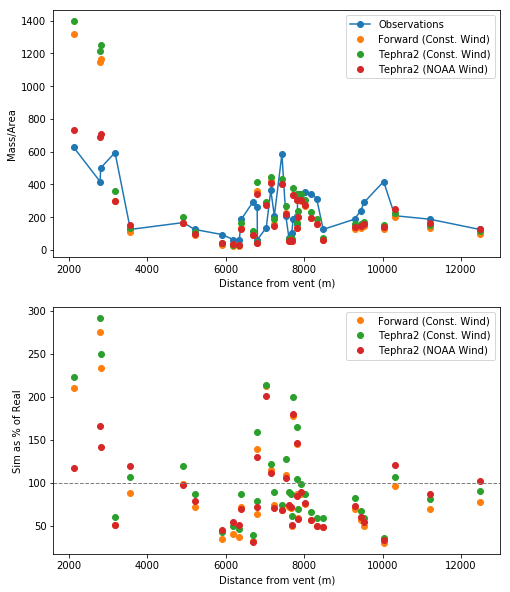

In [10]:
fig, axs = plt.subplots(2,1, figsize=(
        8,10), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C0o-', label="Observations")
# plt.plot(rotdf["radius"].values, rotdf["MassArea"].values, 'C1o-')
axs[0].plot(forward_df["radius"].values, forward_df["MassArea"].values, 'C1o', label="Forward (Const. Wind)")
axs[0].plot(t2_const_df["radius"].values, t2_const_df["MassArea"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[0].legend()
axs[0].set_xlabel("Distance from vent (m)")
axs[0].set_ylabel("Mass/Area")

axs[1].plot(forward_df["radius"].values, forward_df["Residual"].values, 'C1o', label="Forward (Const. Wind)")
axs[1].plot(t2_const_df["radius"].values, t2_const_df["Residual"].values, 'C2o', label="Tephra2 (Const. Wind)")
axs[1].plot(t2_df["radius"].values, t2_df["Residual"].values, 'C3o', label="Tephra2 (NOAA Wind)")
axs[1].axhline(100, linestyle="--", lw=1, c="gray")
axs[1].legend()
axs[1].set_xlabel("Distance from vent (m)")
axs[1].set_ylabel("Sim as % of Real")
plt.show()

========Const. Wind Simulation========
a* = -4.40747	b* = -0.29419            	h1* = 1.94850
a = 1.01219	b = 1.74513	h1 = 26015.94675
Success: True, Optimization terminated successfully.
Iterations: 85
SSE: 2.6505209559926977


,Height,Suspended Mass
0,4430.75,5.567264e+09
1,5776.50,5.351534e+09
2,7122.25,5.109264e+09
3,8468.00,4.852540e+09
4,9813.75,4.584895e+09
5,11159.50,4.307581e+09
6,12505.25,4.020890e+09
7,13851.00,3.724560e+09
8,15196.75,3.417904e+09
9,16542.50,3.099796e+09


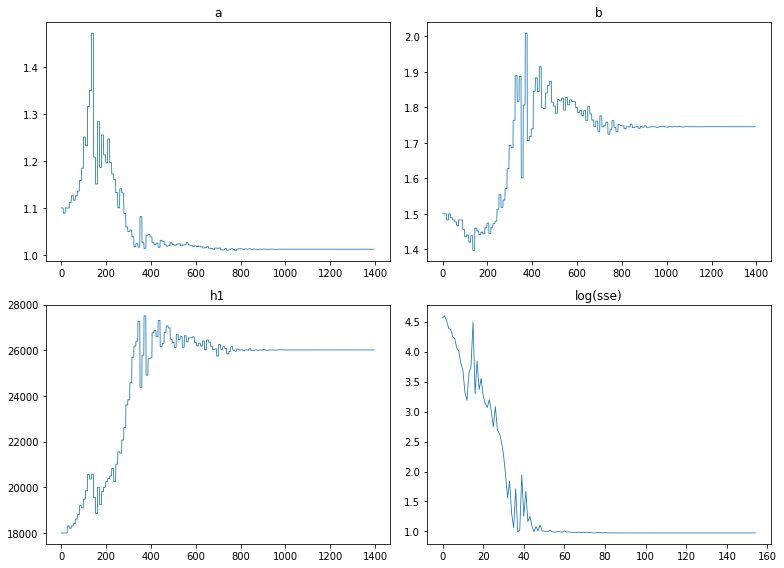

========T2 Const. Wind Simulation========
a* = -3.90617	b* = -0.99500            	h1* = 1.00261
a = 1.02012	b = 1.36972	h1 = 20785.93317
Success: True, Optimization terminated successfully.
Iterations: 120
SSE: 15.62333451157581


,Height,Suspended Mass
0,4430.75,5.659910e+09
1,5776.50,5.560041e+09
2,7122.25,5.414234e+09
3,8468.00,5.240852e+09
4,9813.75,5.043996e+09
5,11159.50,4.823443e+09
6,12505.25,4.576403e+09
7,13851.00,4.297475e+09
8,15196.75,3.977421e+09
9,16542.50,3.599910e+09


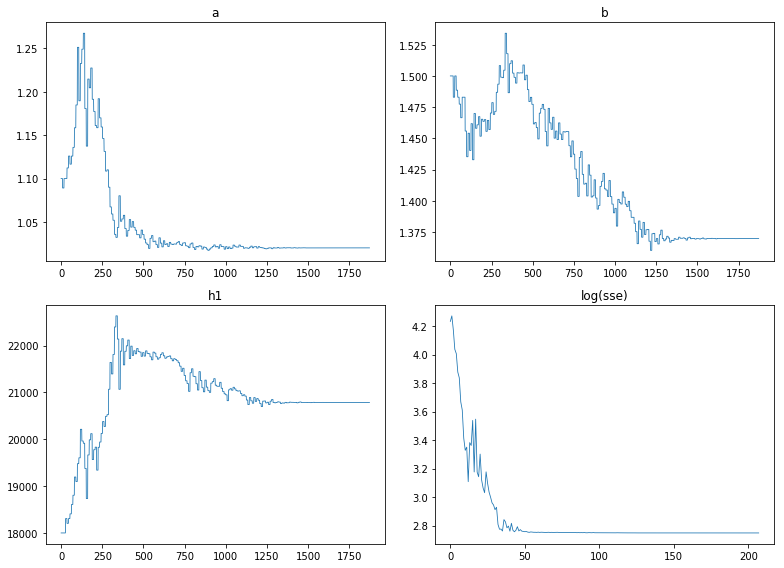

========T2 NOAA Wind Simulation========
a* = -2.19907	b* = -1.97952            	h1* = 3.20503
a = 1.11091	b = 1.13814	h1 = 28807.61007
Success: True, Optimization terminated successfully.
Iterations: 91
SSE: 233.8226297532182


,Height,Suspended Mass
0,4430.75,2.650773e+09
1,5776.50,2.840218e+09
2,7122.25,2.946247e+09
3,8468.00,3.014964e+09
4,9813.75,3.061423e+09
5,11159.50,3.092405e+09
6,12505.25,3.111449e+09
7,13851.00,3.120510e+09
8,15196.75,3.120631e+09
9,16542.50,3.112228e+09


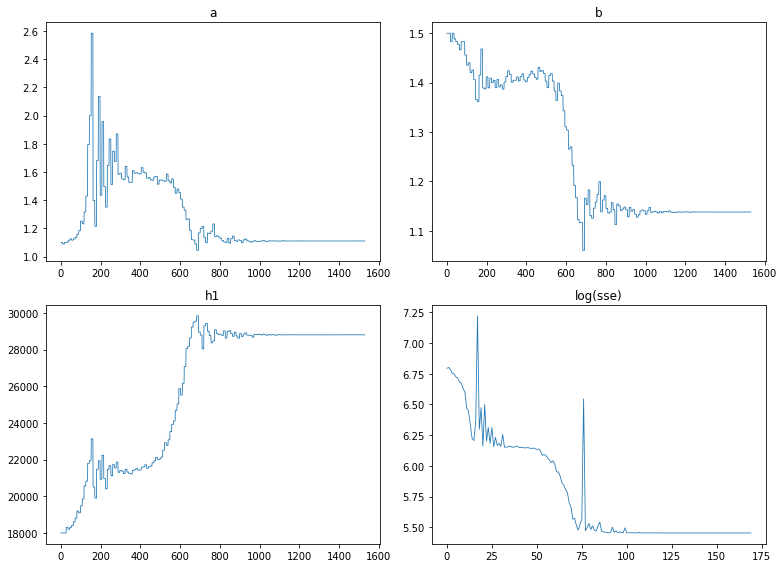

========Observation Data========
a* = -3.46065	b* = 0.76564            	h1* = 2.58954
a = 1.03141	b = 3.15036	h1 = 27830.78531
Success: True, Optimization terminated successfully.
Iterations: 86
SSE: 2620.232761026282


,Height,Suspended Mass
0,4430.75,8.753993e+09
1,5776.50,7.876737e+09
2,7122.25,6.967525e+09
3,8468.00,6.084877e+09
4,9813.75,5.248347e+09
5,11159.50,4.466956e+09
6,12505.25,3.745512e+09
7,13851.00,3.086744e+09
8,15196.75,2.492187e+09
9,16542.50,1.962613e+09


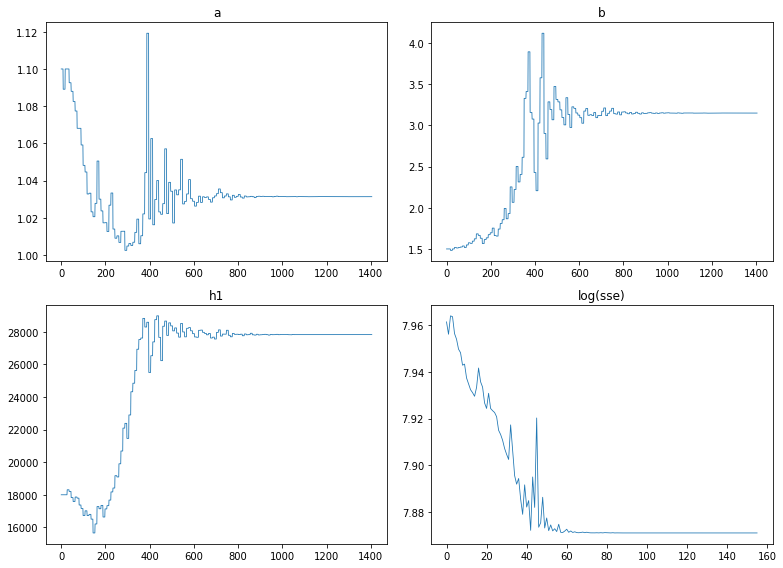

In [11]:
priors_vals = {
    "a": 1.1,
    "b": 1.5,
    "h1": 18000
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True
}

H = 30000

wind_angle = np.radians(55.5)

u = config["WIND_SPEED"]*np.cos(wind_angle)
v = config["WIND_SPEED"]*np.sin(wind_angle)
names = ["Const. Wind Simulation", "T2 Const. Wind Simulation","T2 NOAA Wind Simulation", "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]
inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    print("========%s========"%name)
    out = gaussian_stack_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], H, 2500,
        config["ERUPTION_MASS"],(u,v),
        phi_steps, config["DIFFUSION_COEFFICIENT"],
        config["FALL_TIME_THRESHOLD"], config["EDDY_CONST"],
        invert_params=invert_params,
        priors = priors_vals, 
        column_cap=H)
    inversion_table, _, params, sol, sse, trace, sse_trace = out
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params.values(), H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    fig, axs = plt.subplots(2,2, figsize=(
            11, 8), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(trace[:,2], linewidth=.8)
    axs[2].set_title("h1")

    axs[3].plot(np.log(sse_trace), linewidth=.8)
    axs[3].set_title("log(sse)")

    plt.tight_layout()
    plt.show()



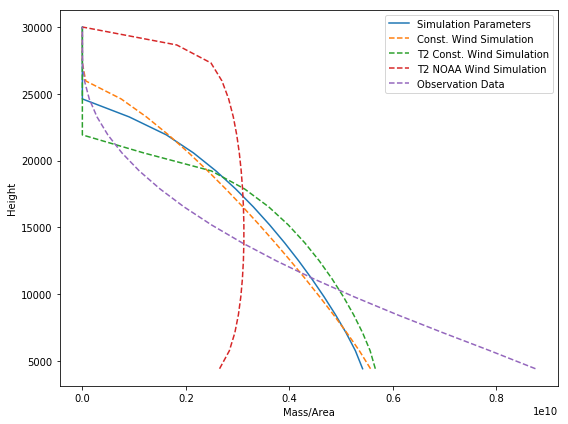

In [12]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()


========Const. Wind Simulation========


c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\users\nmostert\envs\spew\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


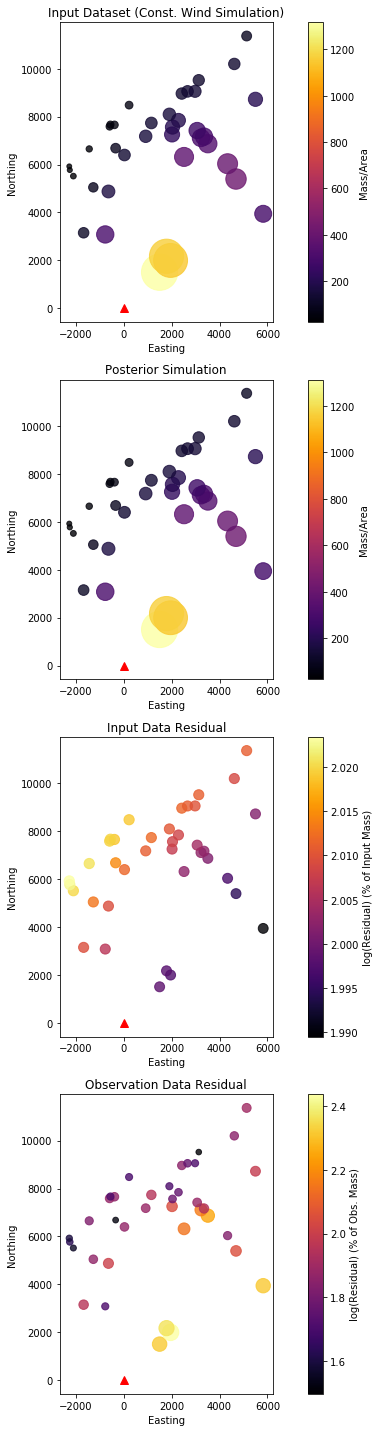

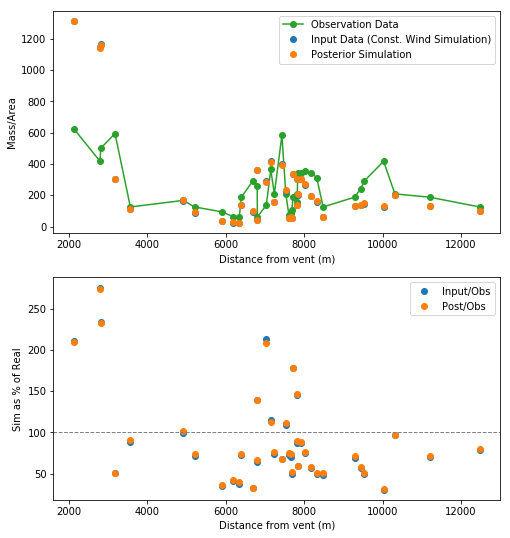

========T2 Const. Wind Simulation========


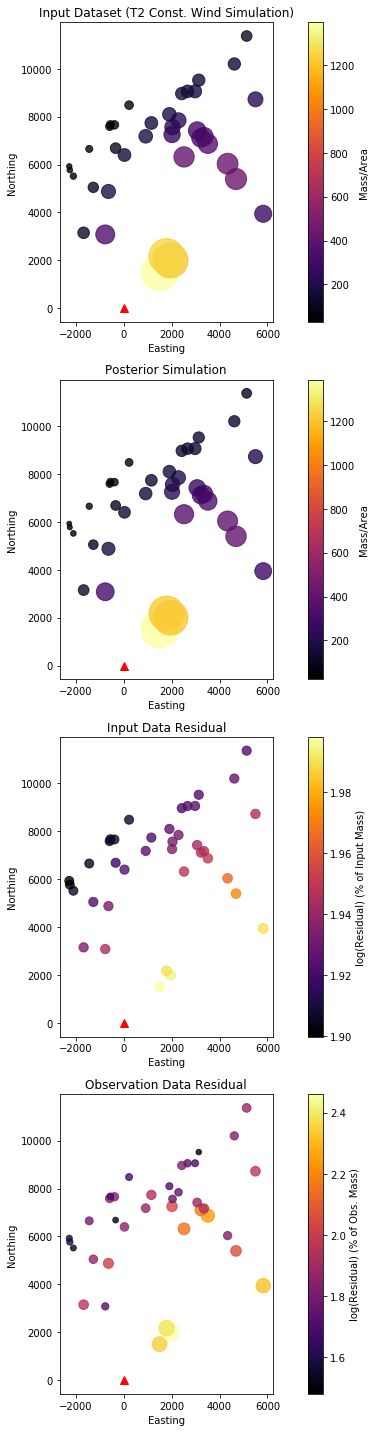

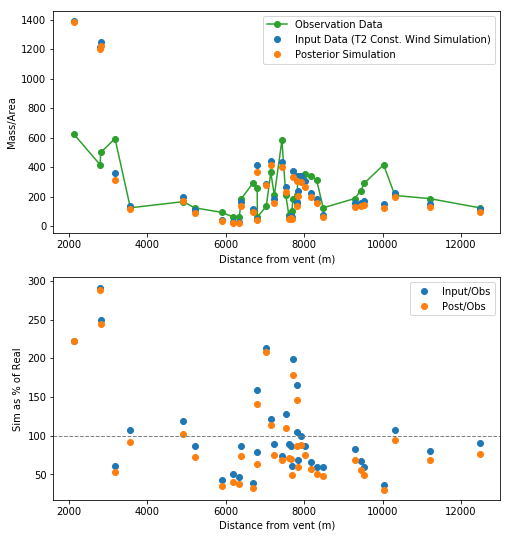

========T2 NOAA Wind Simulation========


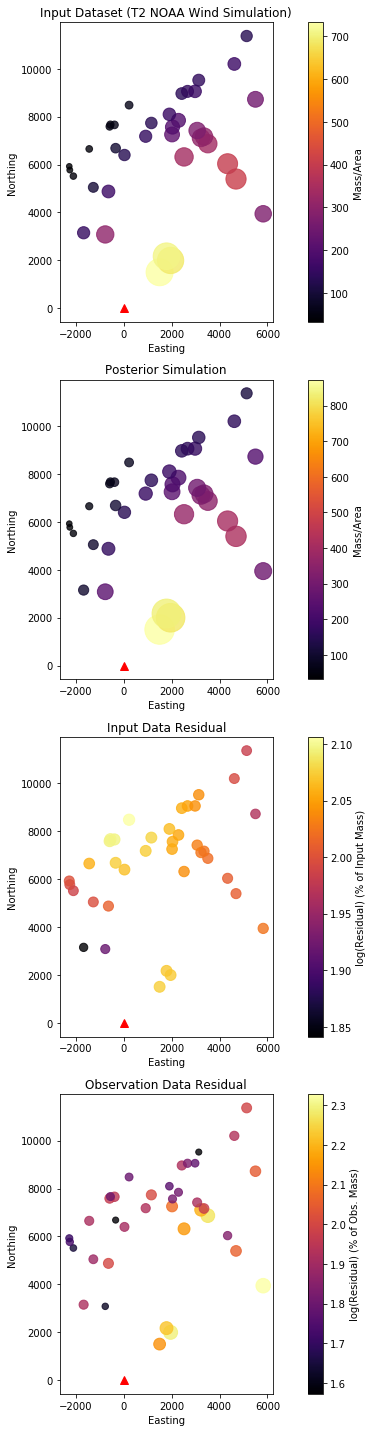

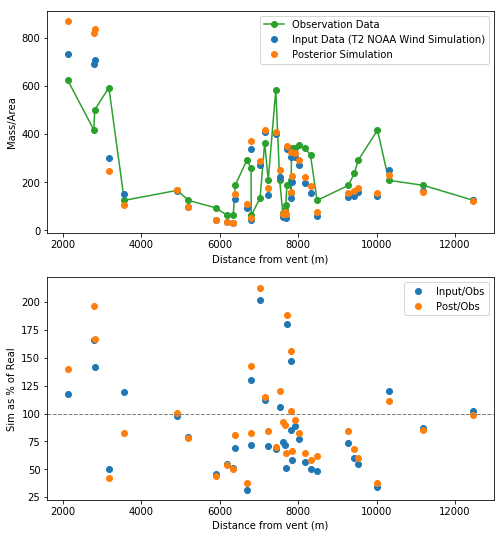

========Observation Data========


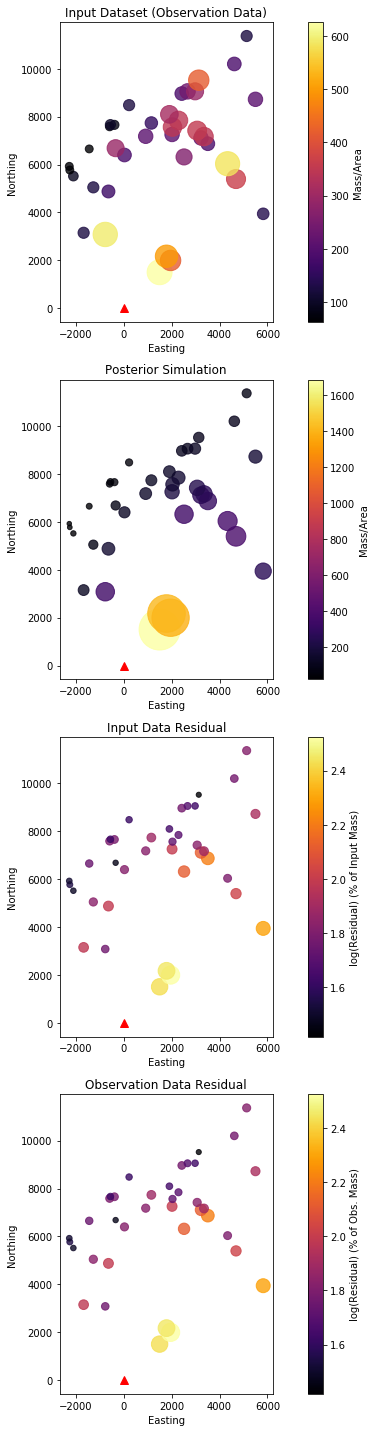

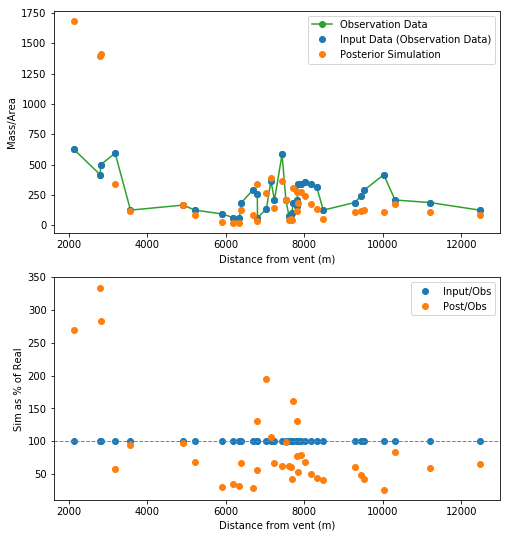

In [13]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]

    post_df = gaussian_stack_forward(
        grid, int(config["COL_STEPS"]), config["VENT_ELEVATION"], 
        params["h1"], 2500, phi_steps, (params["a"],params["b"]), config["ERUPTION_MASS"], 
        (u,v), config["DIFFUSION_COEFFICIENT"], config["EDDY_CONST"],
        config["FALL_TIME_THRESHOLD"]
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"].values/obs_df["MassArea"].values*100
    post_df["Change"] = post_df["MassArea"].values/in_data["MassArea"].values*100
    
    fig, axs = plt.subplots(4,1, figsize=(
            10, 20), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Change",
                title="Input Data Residual", cbar_label="log(Residual) (% of Input Mass)", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=True, values="Residual",
                title="Observation Data Residual", cbar_label="log(Residual) (% of Obs. Mass)", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    
   

In [14]:
# fig, axs = plt.subplots(2,1, figsize=(
#         8, 9), facecolor='w', edgecolor='k')
# axs = axs.ravel()

# axs[0].plot(obs_df["radius"].values, rotdf["MassArea"].values, 'C0-', label="Obs")
# axs[0].plot(df_merge["radius"].values, df_merge["MassArea"].values, 'C1-', label="Prior")
# axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C2-', label="Post")
# axs[0].plot(t2_df["radius"].values, t2_df["MassArea"].values, 'C3-', label="T2")
# axs[0].legend()
# axs[0].set_xlabel("Distance from vent (m)")
# axs[0].set_ylabel("Mass/Area")


# axs[1].plot(prior_res_obs["radius"].values, prior_res_obs["MassArea"].values, 'C1-', label="Prior/Obs")
# axs[1].plot(post_res_obs["radius"].values, post_res_obs["MassArea"].values, 'C2-', label="Post/Obs")
# axs[1].plot(t2_res_df["radius"].values, t2_res_df["MassArea"].values, 'C3-', label="T2/Obs")
# axs[1].legend()
# axs[1].set_xlabel("Distance from vent (m)")
# axs[1].set_ylabel("Residual (%)")
# plt.show()

========Const. Wind Simulation========
a* = -3.89485	b* = -0.42836	            h1* = 1.77402	u* = 1.72849	v* = 2.07786
a = 1.02035	b = 1.65158	            h1 = 25318.80578	u = 5.63215	v = 7.98736
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 640
SSE: 2.0911494895599056


,Height,Suspended Mass
0,4430.75,5.368443e+09
1,5776.50,5.213486e+09
2,7122.25,5.017887e+09
3,8468.00,4.800879e+09
4,9813.75,4.568143e+09
5,11159.50,4.321735e+09
6,12505.25,4.062187e+09
7,13851.00,3.789141e+09
8,15196.75,3.501535e+09
9,16542.50,3.197567e+09


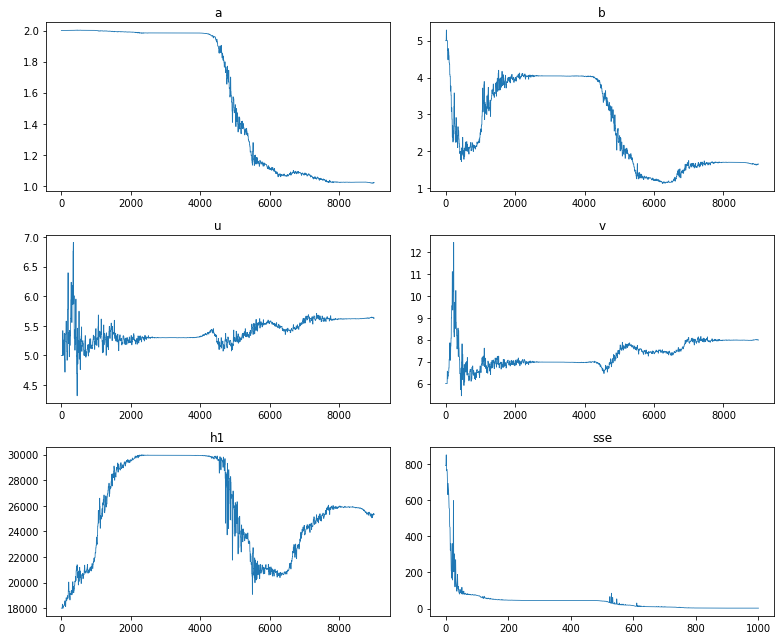

Const. Wind Simulation Run Time: 111.89062 seconds


========T2 Const. Wind Simulation========
a* = -2.29006	b* = 0.05039	            h1* = 1.72498	u* = 1.68637	v* = 2.17622
a = 1.10126	b = 2.05168	            h1 = 25103.83501	u = 5.39984	v = 8.81290
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 643
SSE: 9.48366473747491


,Height,Suspended Mass
0,4430.75,5.903276e+09
1,5776.50,5.899718e+09
2,7122.25,5.697684e+09
3,8468.00,5.405306e+09
4,9813.75,5.059474e+09
5,11159.50,4.677818e+09
6,12505.25,4.270399e+09
7,13851.00,3.843664e+09
8,15196.75,3.402125e+09
9,16542.50,2.949188e+09


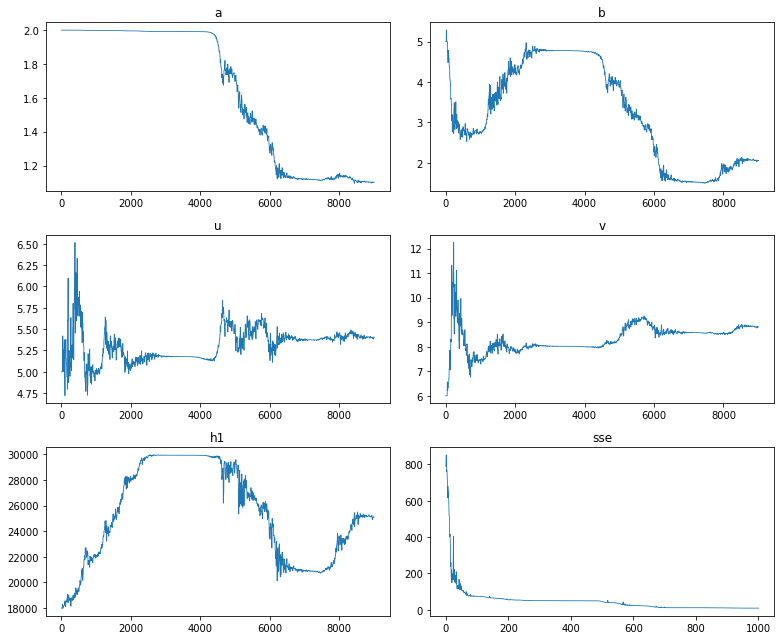

T2 Const. Wind Simulation Run Time: 130.10938 seconds


========T2 NOAA Wind Simulation========
a* = -1.83849	b* = -2.27961	            h1* = 3.19802	u* = 1.72036	v* = 1.99358
a = 1.15906	b = 1.10232	            h1 = 28799.39016	u = 5.58656	v = 7.34180
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 625
SSE: 221.6192150348479


,Height,Suspended Mass
0,4430.75,2.314482e+09
1,5776.50,2.569273e+09
2,7122.25,2.723593e+09
3,8468.00,2.832477e+09
4,9813.75,2.914321e+09
5,11159.50,2.977587e+09
6,12505.25,3.026818e+09
7,13851.00,3.064641e+09
8,15196.75,3.092598e+09
9,16542.50,3.111516e+09


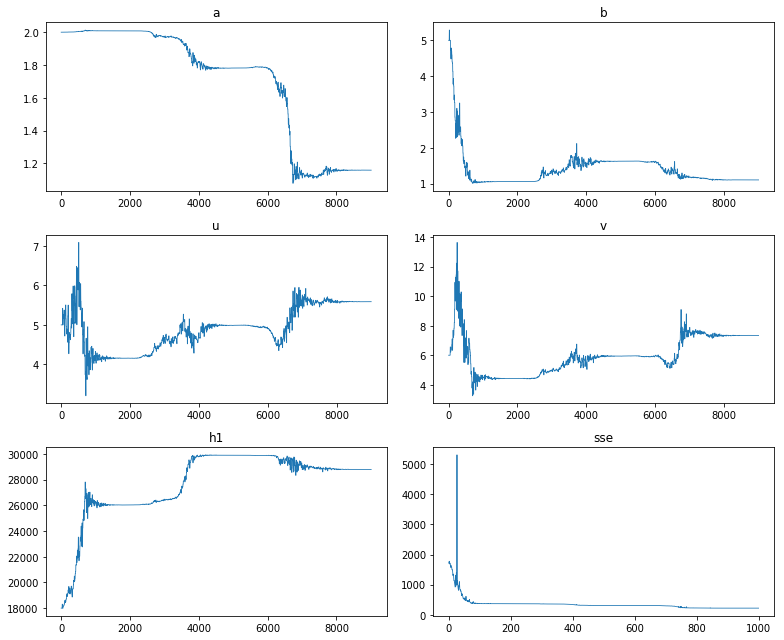

T2 NOAA Wind Simulation Run Time: 152.90625 seconds


========Observation Data========
a* = -0.09530	b* = -0.86118	            h1* = 4.68532	u* = 0.58889	v* = 1.40428
a = 1.90910	b = 1.42266	            h1 = 29724.38029	u = 1.80198	v = 4.07260
Success: True, Optimization terminated successfully.
Iterations: 437
SSE: 866.3987568149621


,Height,Suspended Mass
0,4430.75,5.874025e+08
1,5776.50,1.077873e+09
2,7122.25,1.520676e+09
3,8468.00,1.924645e+09
4,9813.75,2.293224e+09
5,11159.50,2.627753e+09
6,12505.25,2.928418e+09
7,13851.00,3.194596e+09
8,15196.75,3.424973e+09
9,16542.50,3.617526e+09


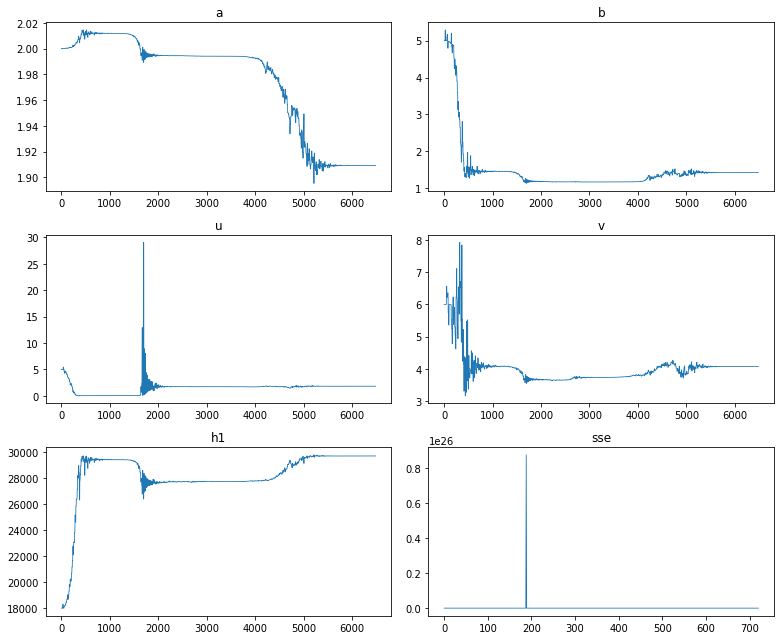

Observation Data Run Time: 98.59375 seconds


Total Run Time: 493.50000 seconds


In [15]:
priors_vals = {
    "a": 2,
    "b": 5,
    "h1": 18000,
    "u": 5,
    "v": 6
}

invert_params = {
    "a" : True,
    "b" : True,
    "h1" : True,
    "u": True,
    "v": True
}

H = 30000

t_tot = process_time()
single_run_time = 0
wind_angle = np.radians(55.5)

names = ["Const. Wind Simulation", 
         "T2 Const. Wind Simulation",
         "T2 NOAA Wind Simulation", 
         "Observation Data"]
data_sets = [forward_df, t2_const_df, t2_df, obs_df]

inverted_masses_list = []
params_list = []
for name, df in zip(names, data_sets):
    t = process_time()
    
    print("========%s========"%name)
    out = gaussian_stack_wind_inversion(
        df, len(df), 20, config["VENT_ELEVATION"], 
        H, 2500, 
        config["ERUPTION_MASS"], phi_steps,
        config["DIFFUSION_COEFFICIENT"], 
        config["FALL_TIME_THRESHOLD"], 
        config["EDDY_CONST"],
        invert_params = invert_params,
        priors=priors_vals,
        column_cap=H)
    inversion_table, params, sol, sse, trace, wind_trace, sse_trace = out
    params_no_wind = list(params.values())
    params_no_wind = params_no_wind[:-2]
    
    inv_mass, _, _, _ = beta_transform(*param_inv_transform(*params_no_wind, H), 
                          config["ERUPTION_MASS"], 
                          inversion_table["Height"], config["VENT_ELEVATION"], H)
    inverted_masses_list += [inv_mass]
    params_list += [params]
    display(inversion_table)
    trace = np.array(trace)
    wind_trace = np.array(wind_trace)
    fig, axs = plt.subplots(3,2, figsize=(
            11, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    axs[0].plot(trace[:,0], linewidth=.8)
    axs[0].set_title("a")

    axs[1].plot(trace[:,1], linewidth=.8)
    axs[1].set_title("b")

    axs[2].plot(wind_trace[:,0], linewidth=.8)
    axs[2].set_title("u")

    axs[3].plot(wind_trace[:,1], linewidth=.8)
    axs[3].set_title("v")


    axs[4].plot(trace[:,2], linewidth=.8)
    axs[4].set_title("h1")

    axs[5].plot(sse_trace, linewidth=.8)
    axs[5].set_title("sse")

    plt.tight_layout()
    # plt.savefig("colima/real_trace.png", dpi=200, format='png')
    plt.show()
    
    run_time = process_time() - t
    print("%s Run Time: %.5f seconds\n\n"%(name, run_time))


total_run_time = process_time() - t_tot

print("Total Run Time: %.5f seconds"%(total_run_time))

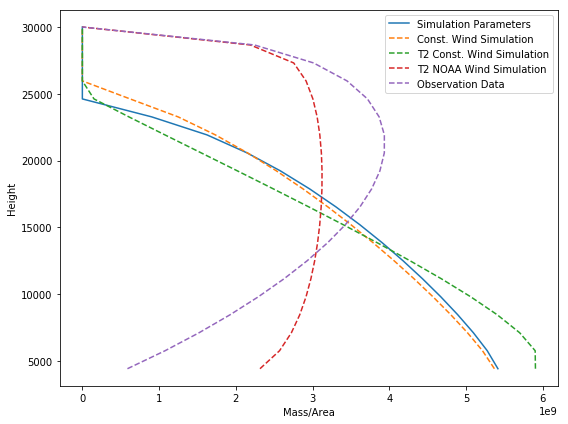

In [16]:
fig, ax1 = plt.subplots(1,1, figsize=(
    8, 6), facecolor='w', edgecolor='k')

q_dist = beta(config["ALPHA"],config["BETA"])

q_mass = mass_dist_in_plume(config["ALPHA"],config["BETA"], config["VENT_ELEVATION"], 
            config["PLUME_HEIGHT"],
            inversion_table["Height"],
            config["ERUPTION_MASS"])

ax1.plot(q_mass, inversion_table["Height"], label="Simulation Parameters")
for name, mass in zip(names, inverted_masses_list):
    ax1.plot(mass, 
         inversion_table["Height"], 
         '--', label=name)
ax1.legend()
# ax1.set_title("Mass in Column as inverted from various datasets")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

plt.tight_layout()
plt.show()

In [17]:
for name, params, mass, in_data in zip(names, params_list, inverted_masses_list, data_sets):
    print("========%s========"%name)
    q_dist = beta(params["a"],params["b"])

    grid = obs_df[["Easting", "Northing"]]
    u = params["u"]
    v = params["v"]
    post_df = gaussian_stack_forward(
        config, globs, grid, int(config["COL_STEPS"]), 0, 
        params["h1"], phi_steps, q_dist, config["ERUPTION_MASS"], (u,v)
    )
    
    post_df["radius"] = np.sqrt(post_df["Easting"]**2 + post_df["Northing"]**2)
    post_df = post_df.sort_values(by=['radius'])
    post_df["Residual"] = post_df["MassArea"]/obs_df["MassArea"]*100
    post_df["Change"] = post_df["MassArea"]/in_data["MassArea"]*100
    
    fig, axs = plt.subplots(2,2, figsize=(
            10, 10), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    vis.plot_sample(in_data, vent=(0,0), log=False, 
                title="Input Dataset (%s)"%name, cbar_label="Mass/Area", ax=axs[0])
    vis.plot_sample(post_df, vent=(0,0), log=False, 
                title="Posterior Simulation", cbar_label="Mass/Area", ax=axs[1])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Change",
                title="Input Data Residual", cbar_label="Mass/Area", ax=axs[2])
    vis.plot_sample(post_df, vent=(0,0), log=False, values="Residual",
                title="Observation Data Residual", cbar_label="Mass/Area", ax=axs[3])

    plt.tight_layout()
    plt.show()

    
    fig, axs = plt.subplots(2,1, figsize=(
            8, 9), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    axs[0].plot(obs_df["radius"].values, obs_df["MassArea"].values, 'C2o-', label="Observation Data")
    axs[0].plot(in_data["radius"].values, in_data["MassArea"].values, 'C0o', label="Input Data (%s)"%name)
    axs[0].plot(post_df["radius"].values, post_df["MassArea"].values, 'C1o', label="Posterior Simulation")
    axs[0].legend()
    axs[0].set_xlabel("Distance from vent (m)")
    axs[0].set_ylabel("Mass/Area")


    axs[1].plot(in_data["radius"].values, in_data["Residual"].values, 'C0o', label="Input/Obs")
    axs[1].plot(post_df["radius"].values, post_df["Residual"].values, 'C1o', label="Post/Obs")
    axs[1].axhline(100, linestyle="--", lw=1, c="gray")
    axs[1].legend()
    axs[1].set_xlabel("Distance from vent (m)")
    axs[1].set_ylabel("Sim as % of Real")
    plt.show()
    

========Const. Wind Simulation========


TypeError: gaussian_stack_forward() missing 2 required positional arguments: 'eddy_constant' and 'fall_time_threshold'

In [ ]:


a = [1,2,3,4,5,6]

b, c, d, \
    e, f, g = a

print(b, c, d, e, f, g)